In [ ]:
# dowaload the packge if needed
! pip install matplotlib



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


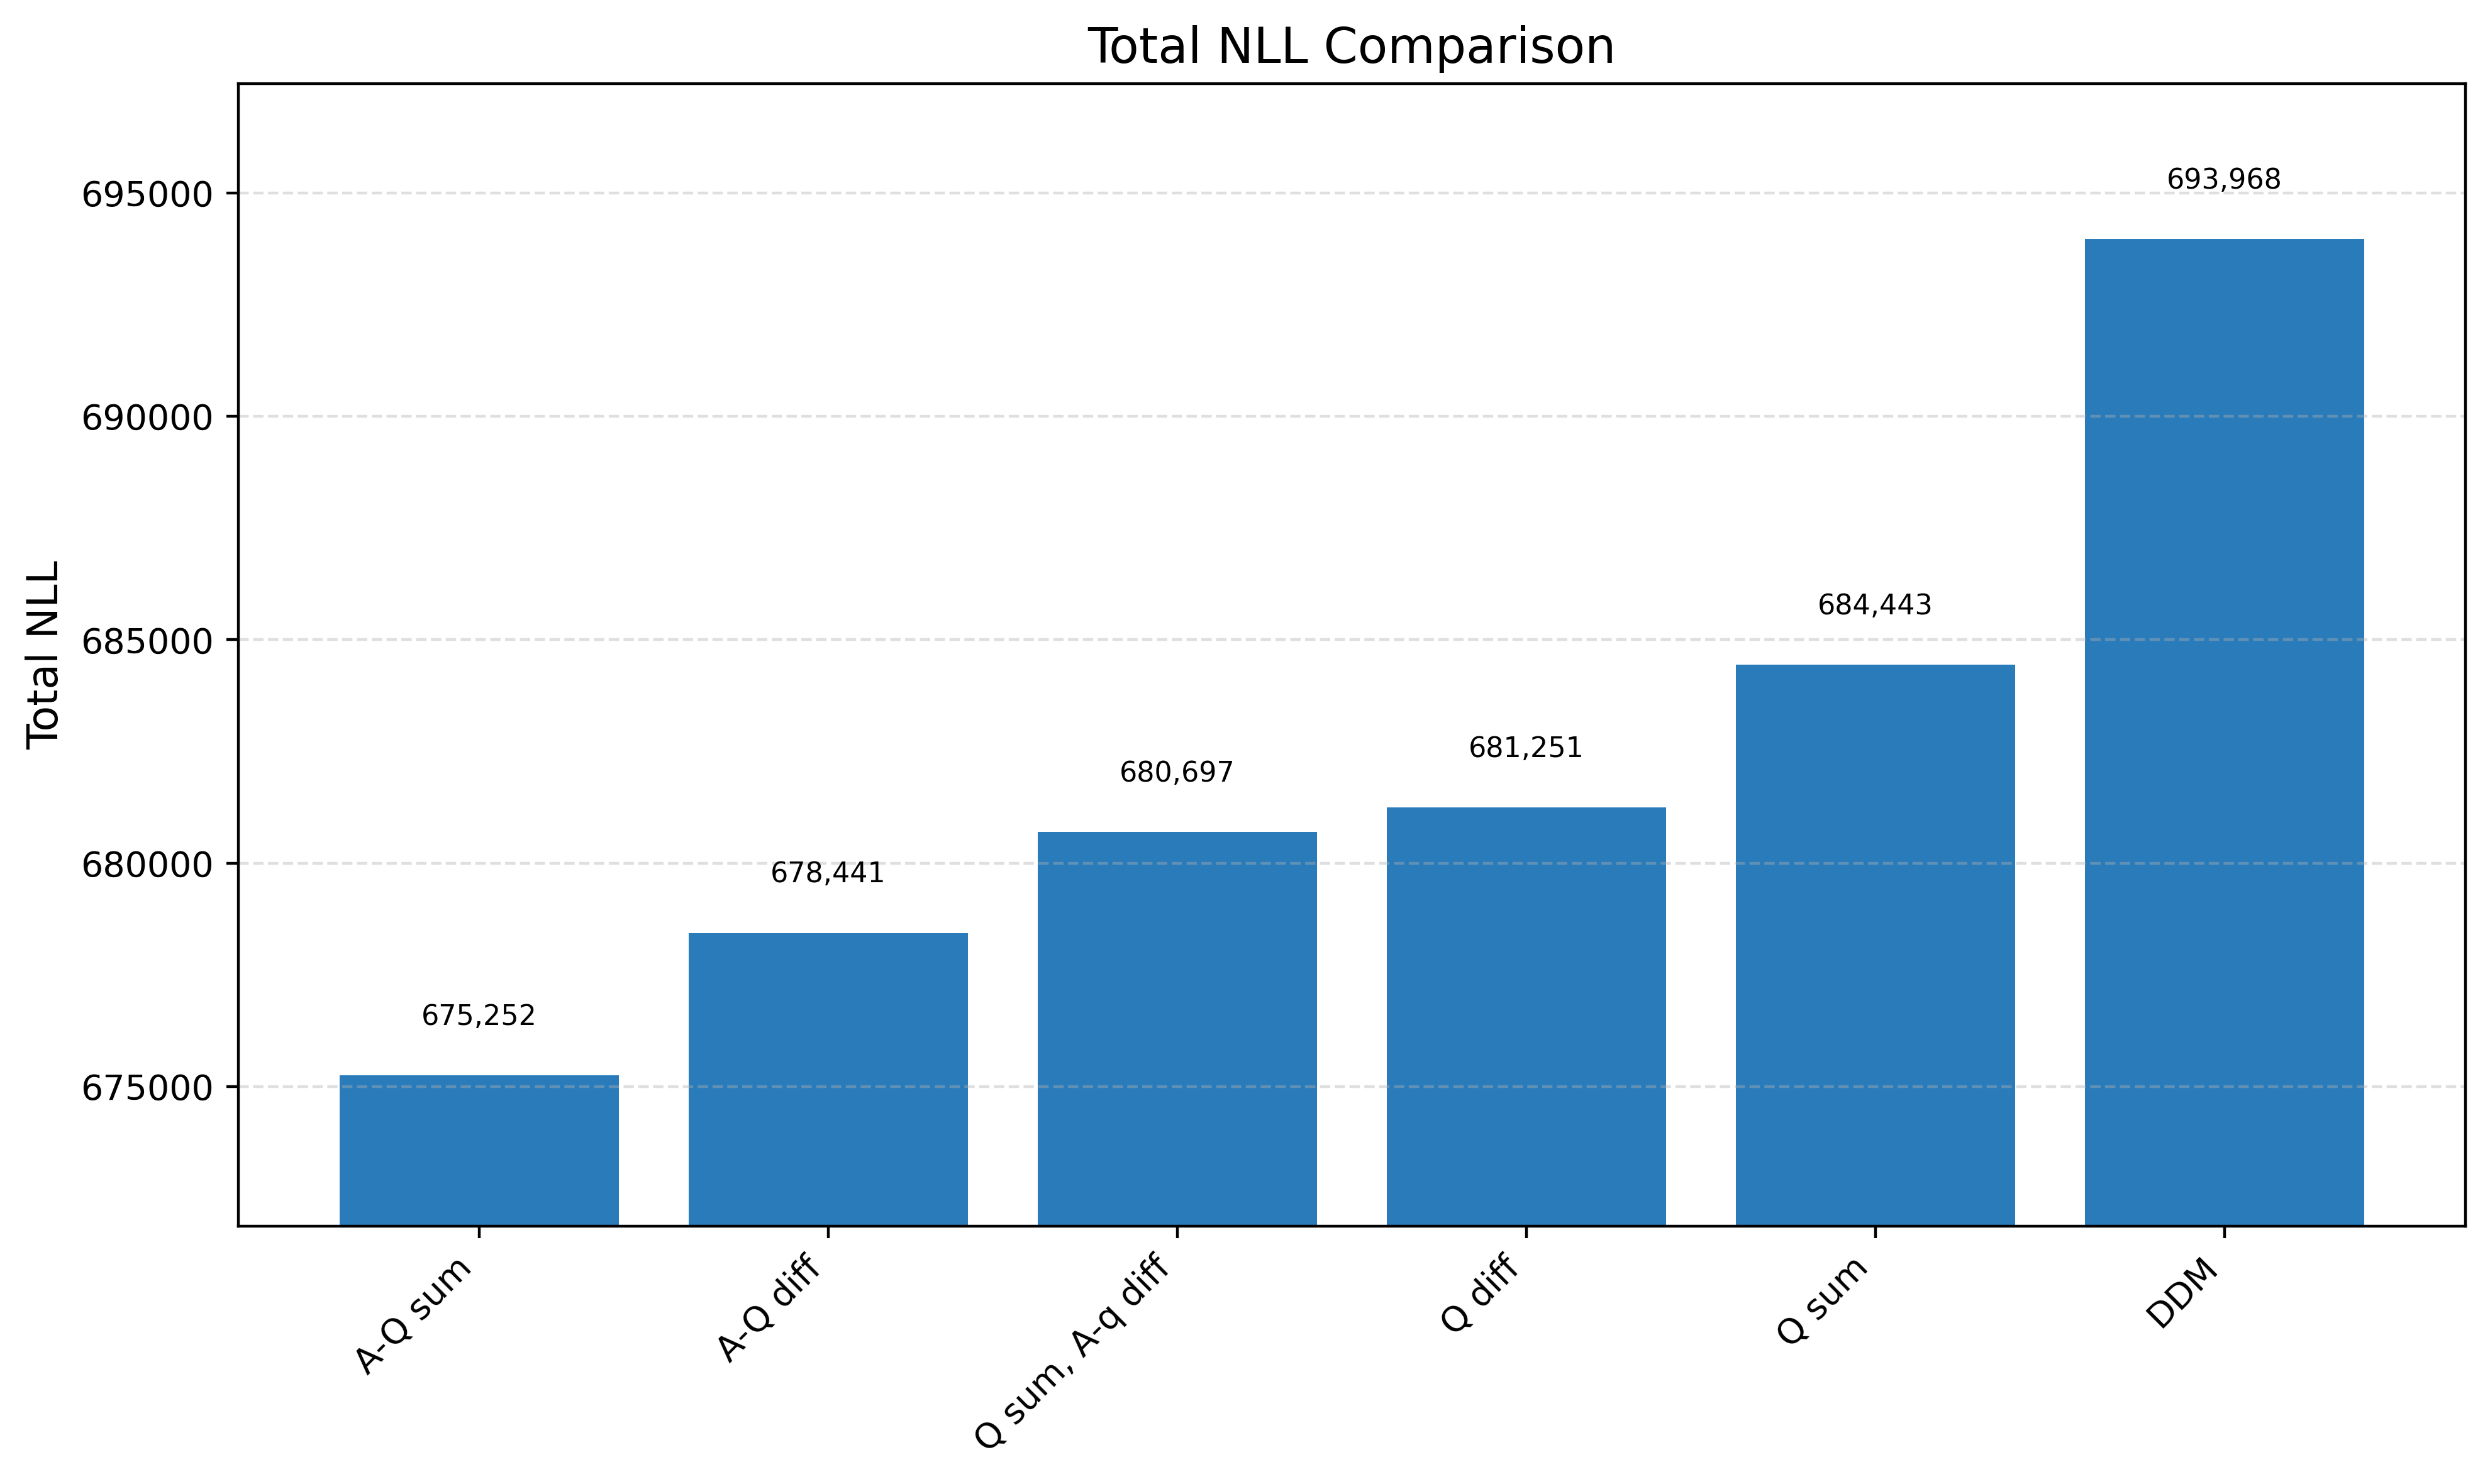

In [10]:
# model comprasion. I sum them together by hand. 
import matplotlib.pyplot as plt

model_nlls = {
    'DDM': 693968.2516, # 2(how many parameters if used for AIC or BIC, but wont be needed as they are appromxialy the same)
    'Q diff': 681251.4047, # 3
    'Q sum': 684443.3046, # 3
    'A-Q sum': 675251.64,# 4
    'A-Q diff': 678441.21,#4
    'Q sum, A-q diff': 680697.34#4
}

sorted_items = sorted(model_nlls.items(), key=lambda x: x[1])
sorted_names = [item[0] for item in sorted_items]
sorted_nlls = [item[1] for item in sorted_items]

plt.figure(figsize=(10, 6), dpi=400)
bars = plt.bar(sorted_names, sorted_nlls, color='#2a7bba')
plt.ylabel('Total NLL', fontsize=12)
plt.title('Total NLL Comparison', fontsize=14)
plt.ylim(min(sorted_nlls) * 0.995, max(sorted_nlls) * 1.005)  

for bar, val in zip(bars, sorted_nlls):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 1000, f"{val:,.0f}",
             ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [11]:
# graphing function for paramater correlation
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

female_color = '#D55672'
male_color = '#0075A2'

ratIDs = np.array([
    'rat136','rat137','rat139','rat147','rat150','rat151','rat152',
    'rat195','rat198','rat199','rat200','rat224','rat225','rat228'
])

femaleIDs = {'rat150','rat152','rat224','rat225','rat228'}
is_female = np.isin(ratIDs, list(femaleIDs))
is_male = ~is_female


def plot_corr(x, y, x_label, y_label, title, stat_loc='lower right'):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=400)

    slope_f, intercept_f = np.polyfit(x[is_female], y[is_female], 1)
    slope_m, intercept_m = np.polyfit(x[is_male], y[is_male], 1)
    ax.plot(x[is_female], slope_f * x[is_female] + intercept_f, color=female_color, linestyle='--', linewidth=2)
    ax.plot(x[is_male], slope_m * x[is_male] + intercept_m, color=male_color, linestyle='--', linewidth=2)

    r_f, p_f = pearsonr(x[is_female], y[is_female])
    r_m, p_m = pearsonr(x[is_male], y[is_male])
    pf_txt = '<.001' if p_f < 0.001 else ('<.01' if p_f < 0.01 else f"={p_f:.3f}")
    pm_txt = '<.001' if p_m < 0.001 else ('<.01' if p_m < 0.01 else f"={p_m:.3f}")
    txt_f = f"Female: r = {r_f:.2f}, p {pf_txt}"
    txt_m = f"Male:   r = {r_m:.2f}, p {pm_txt}"

    stat_locations = {
        'upper left':  (0.02, 0.98, 'left', 'top'),
        'upper right': (0.98, 0.98, 'right', 'top'),
        'lower left':  (0.02, 0.02, 'left', 'bottom'),
        'lower right': (0.98, 0.02, 'right', 'bottom'),
    }
    x0, y0, ha, va = stat_locations.get(stat_loc, (0.98, 0.02, 'right', 'bottom'))

    ax.text(x0, y0, txt_f,
            fontsize=8, ha=ha, va=va,
            transform=ax.transAxes,
            color=female_color)

    ax.text(x0, y0 - 0.07 if va == 'top' else y0 + 0.07, txt_m,
            fontsize=8, ha=ha, va=va,
            transform=ax.transAxes,
            color=male_color)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=11)
    ax.grid(False)

    plt.tight_layout()
    plt.show()


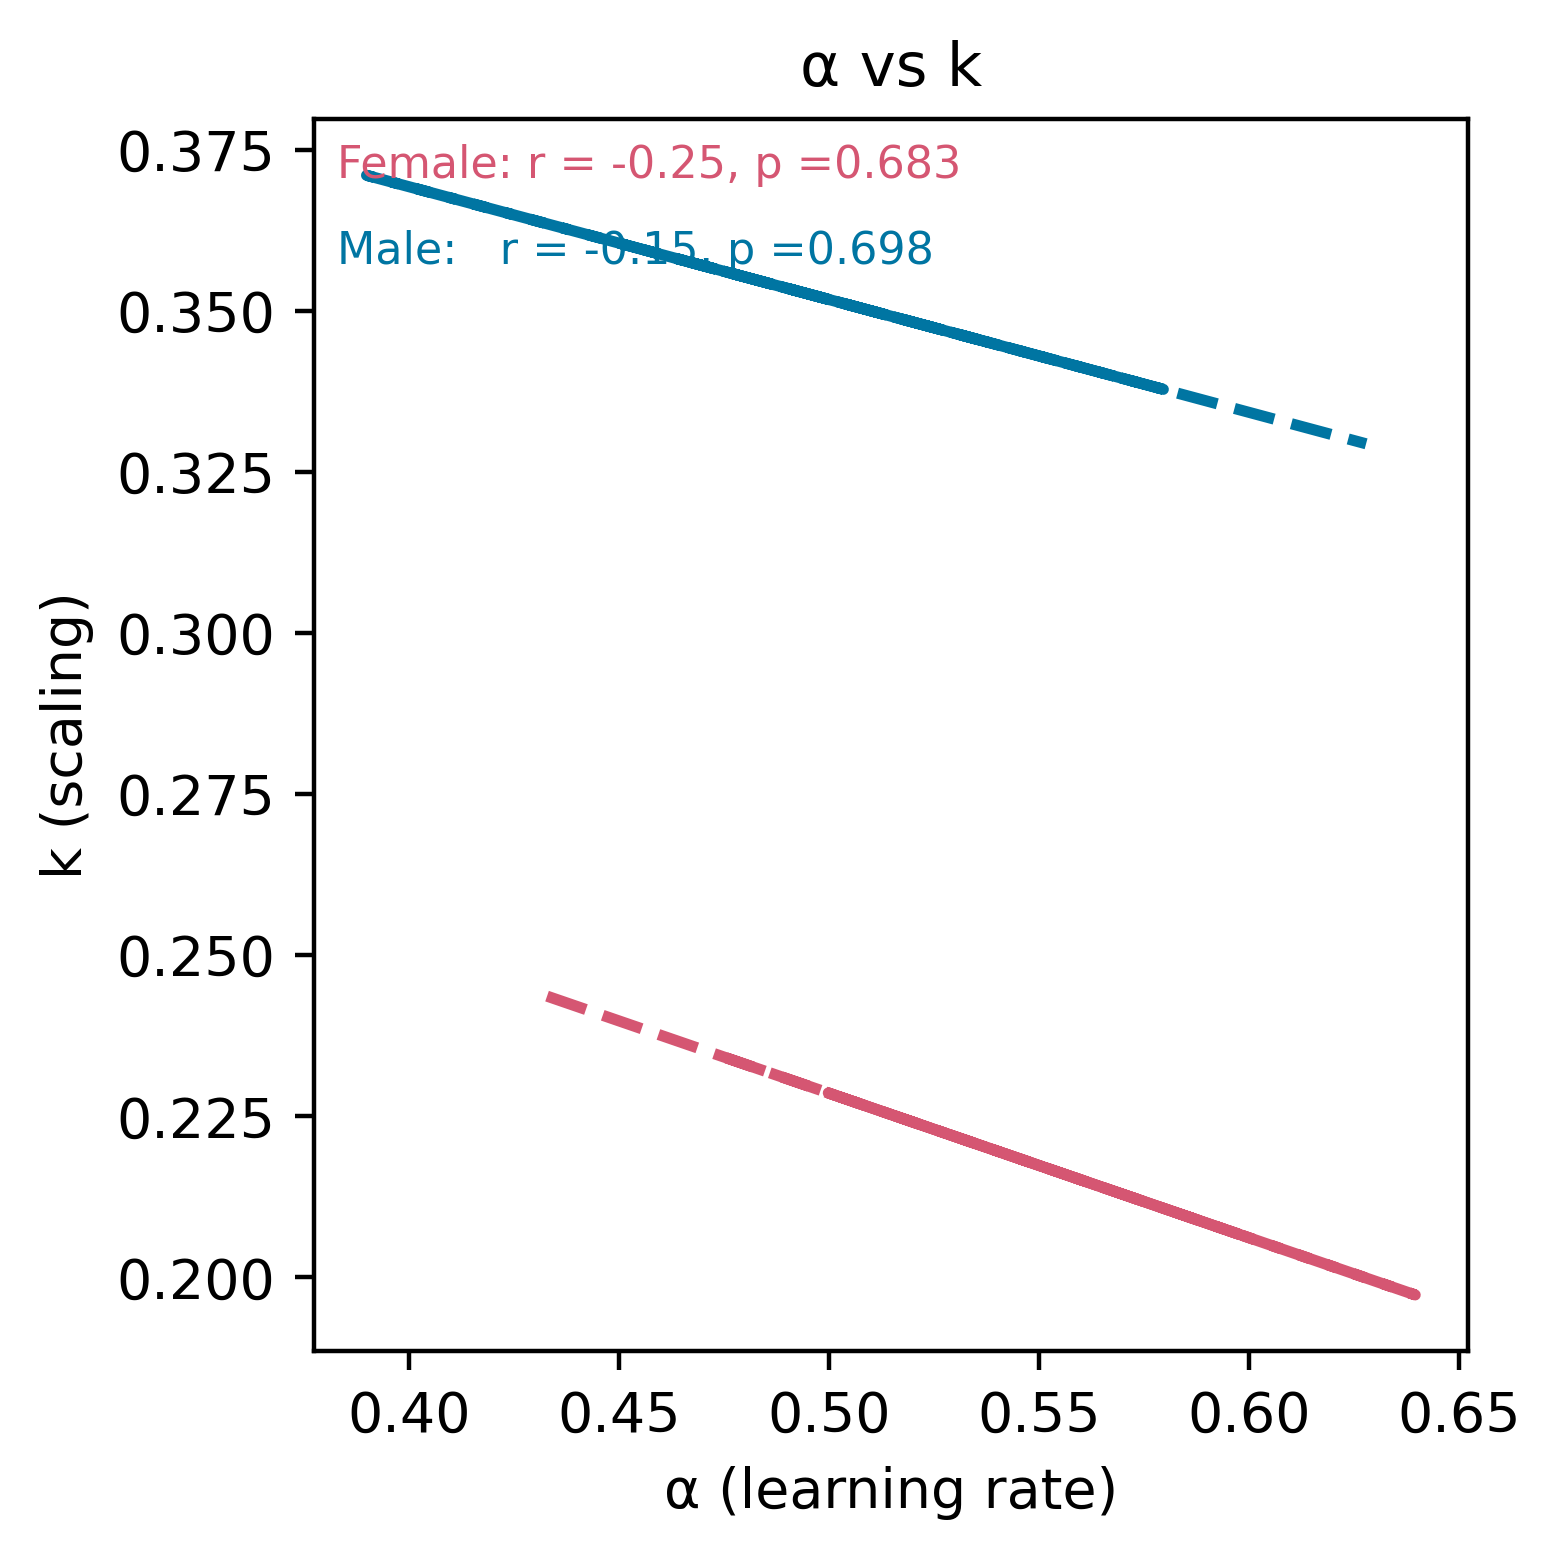

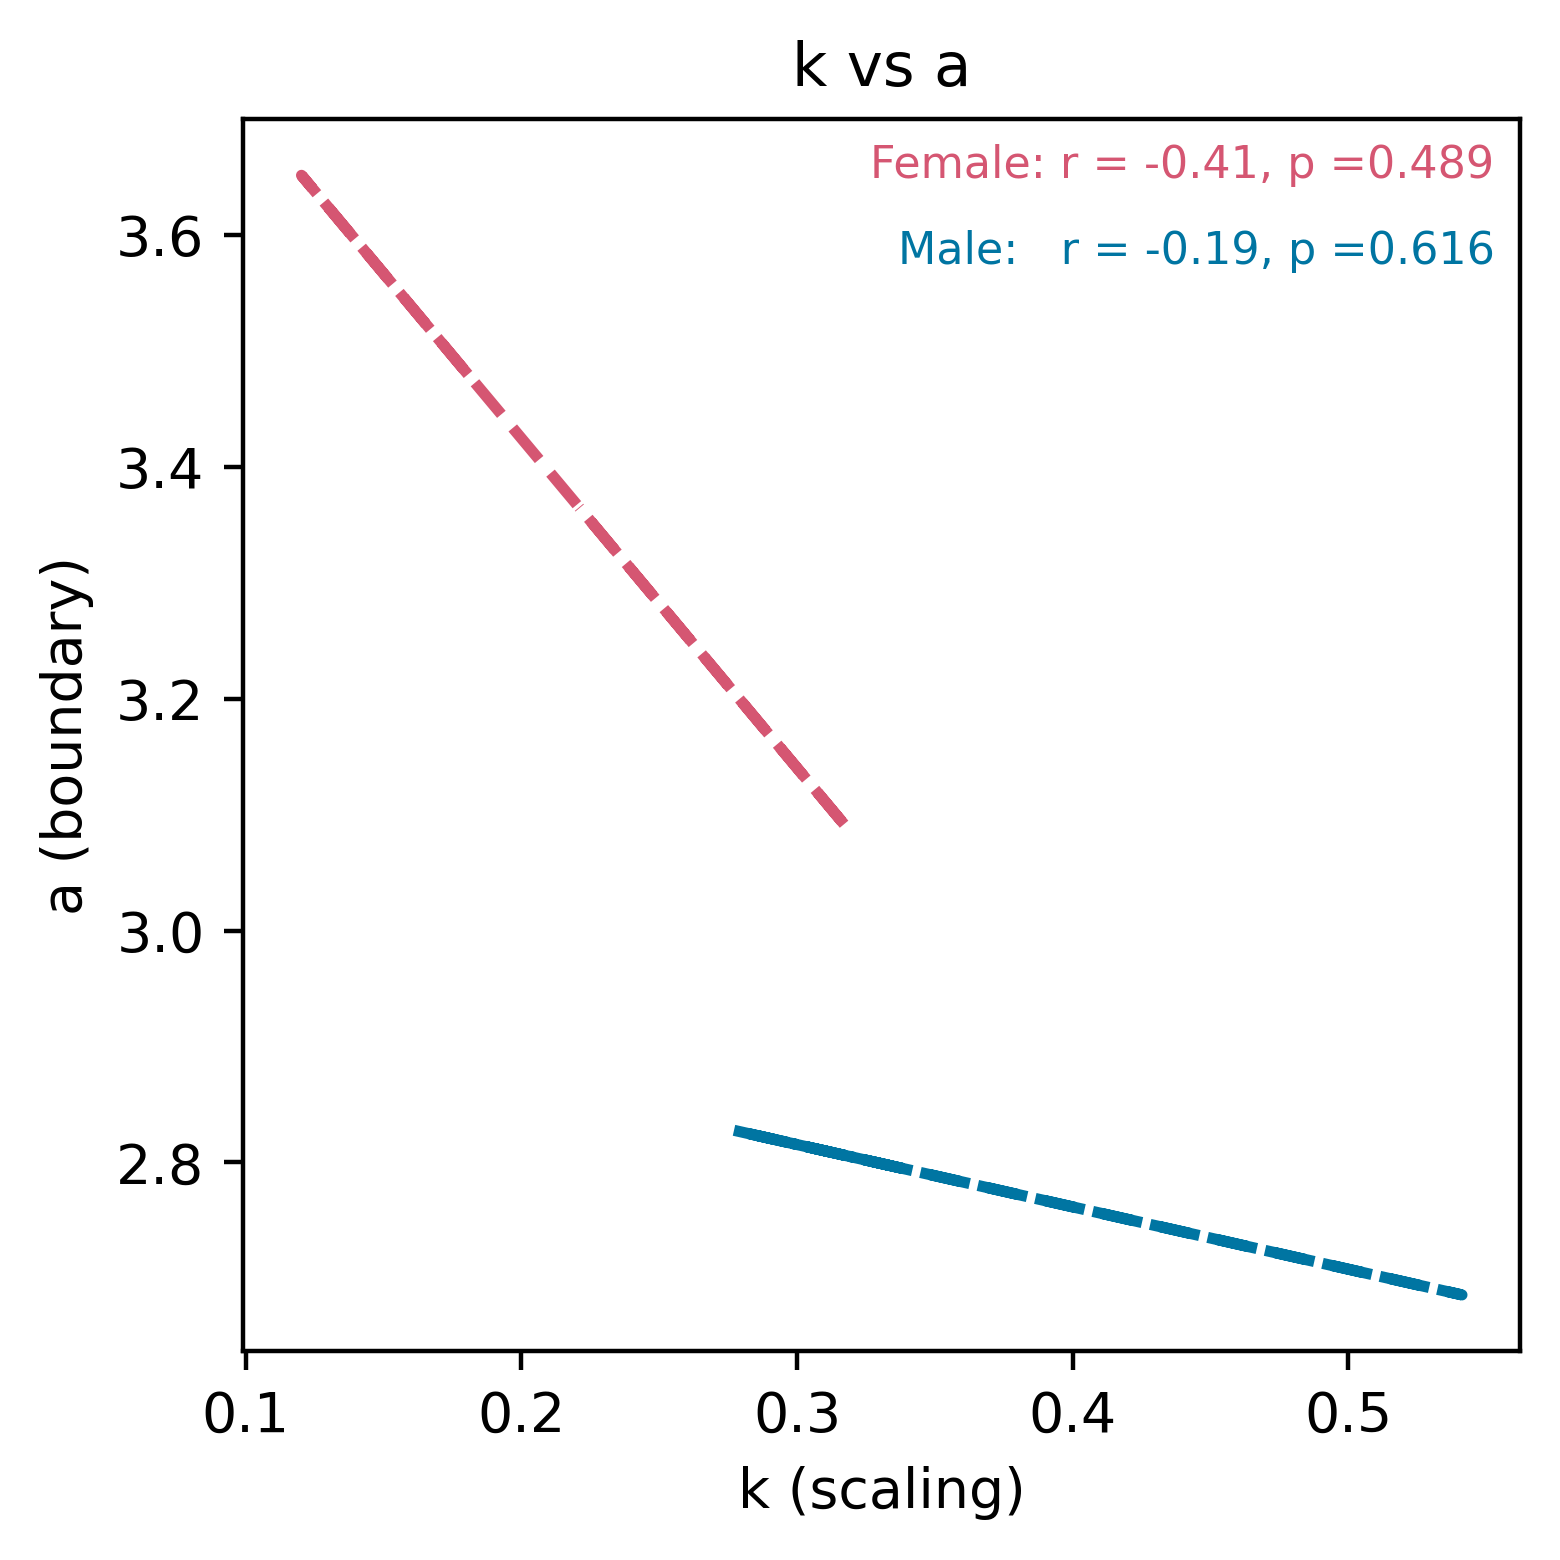

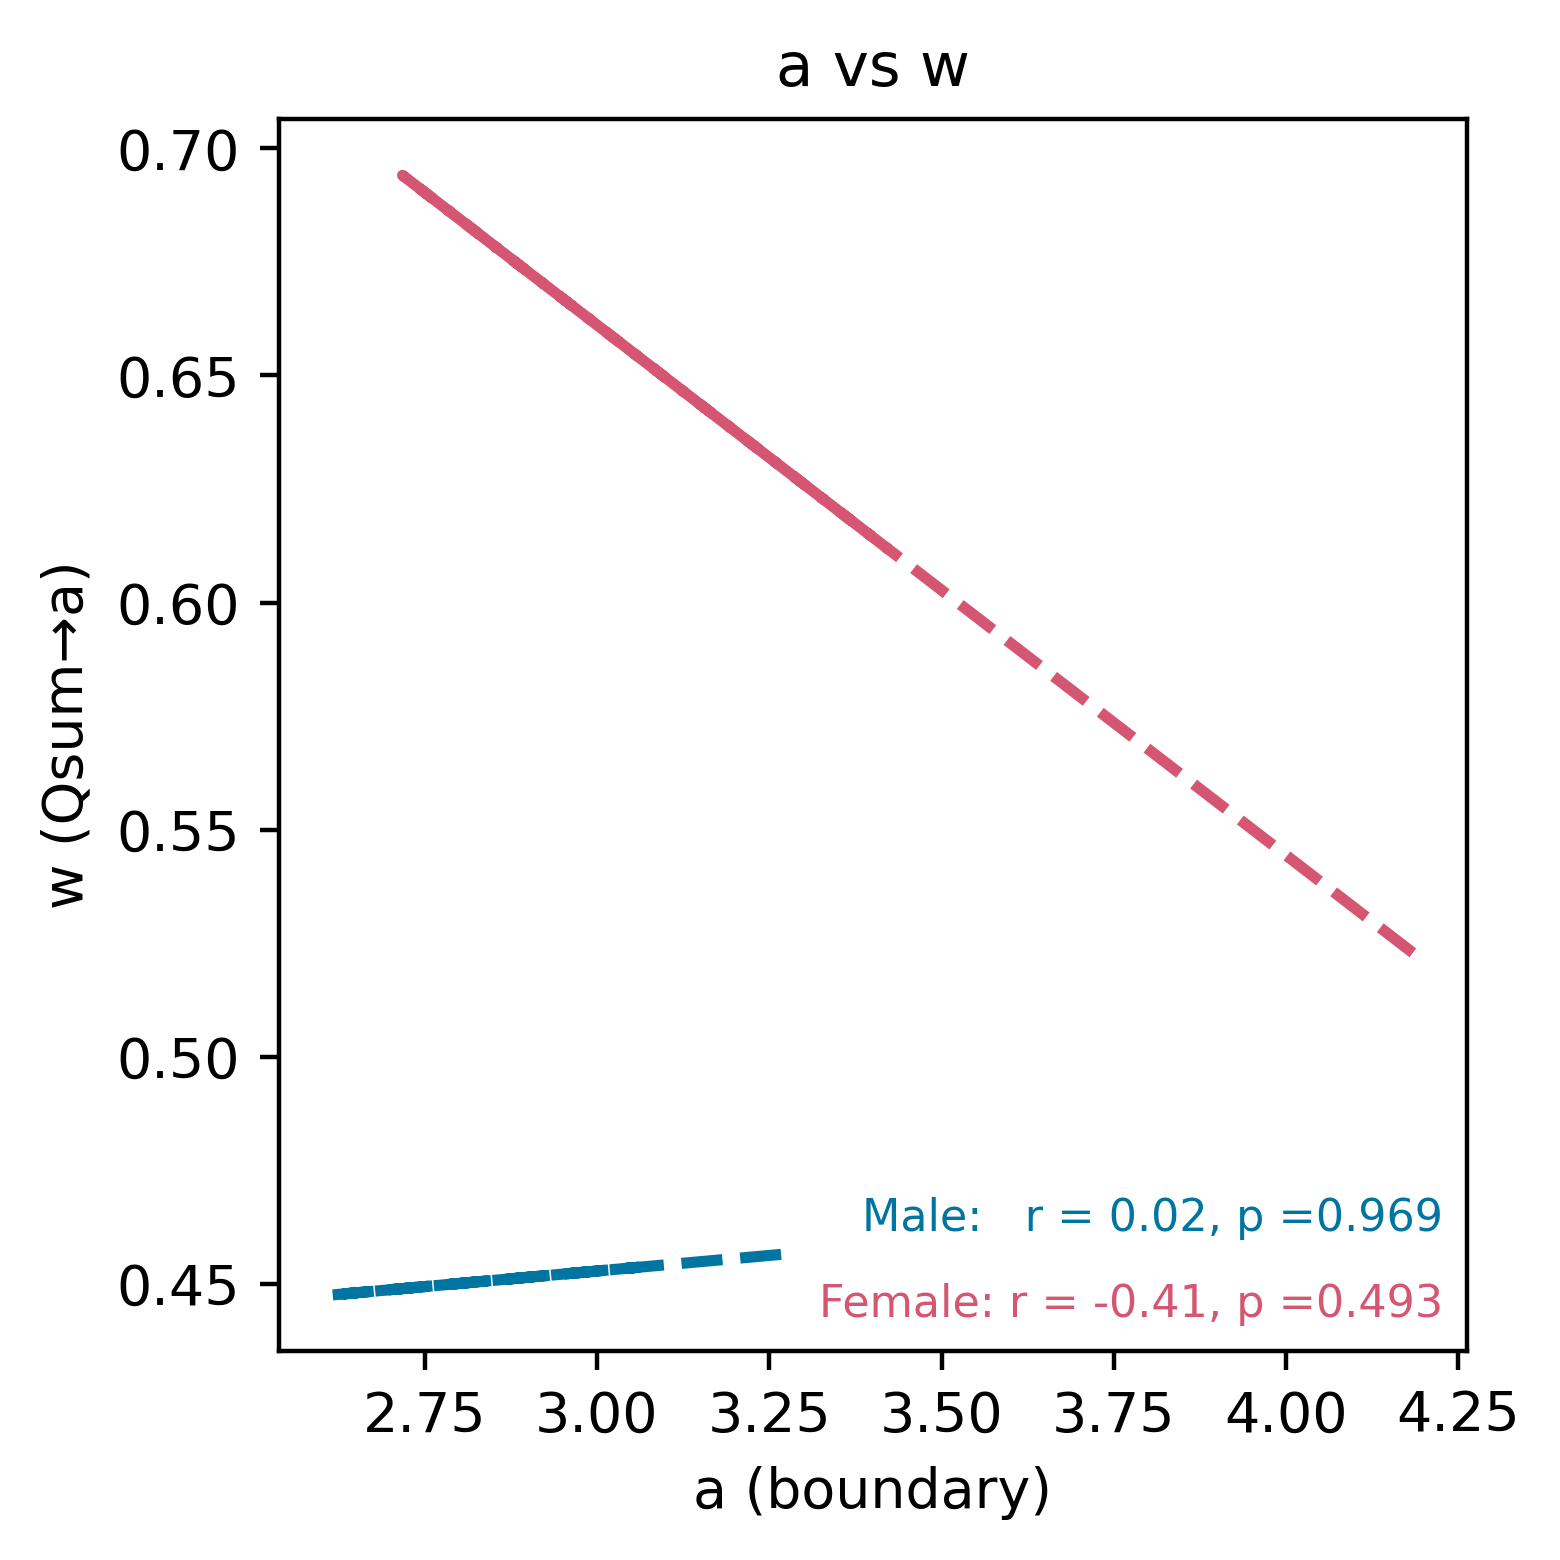

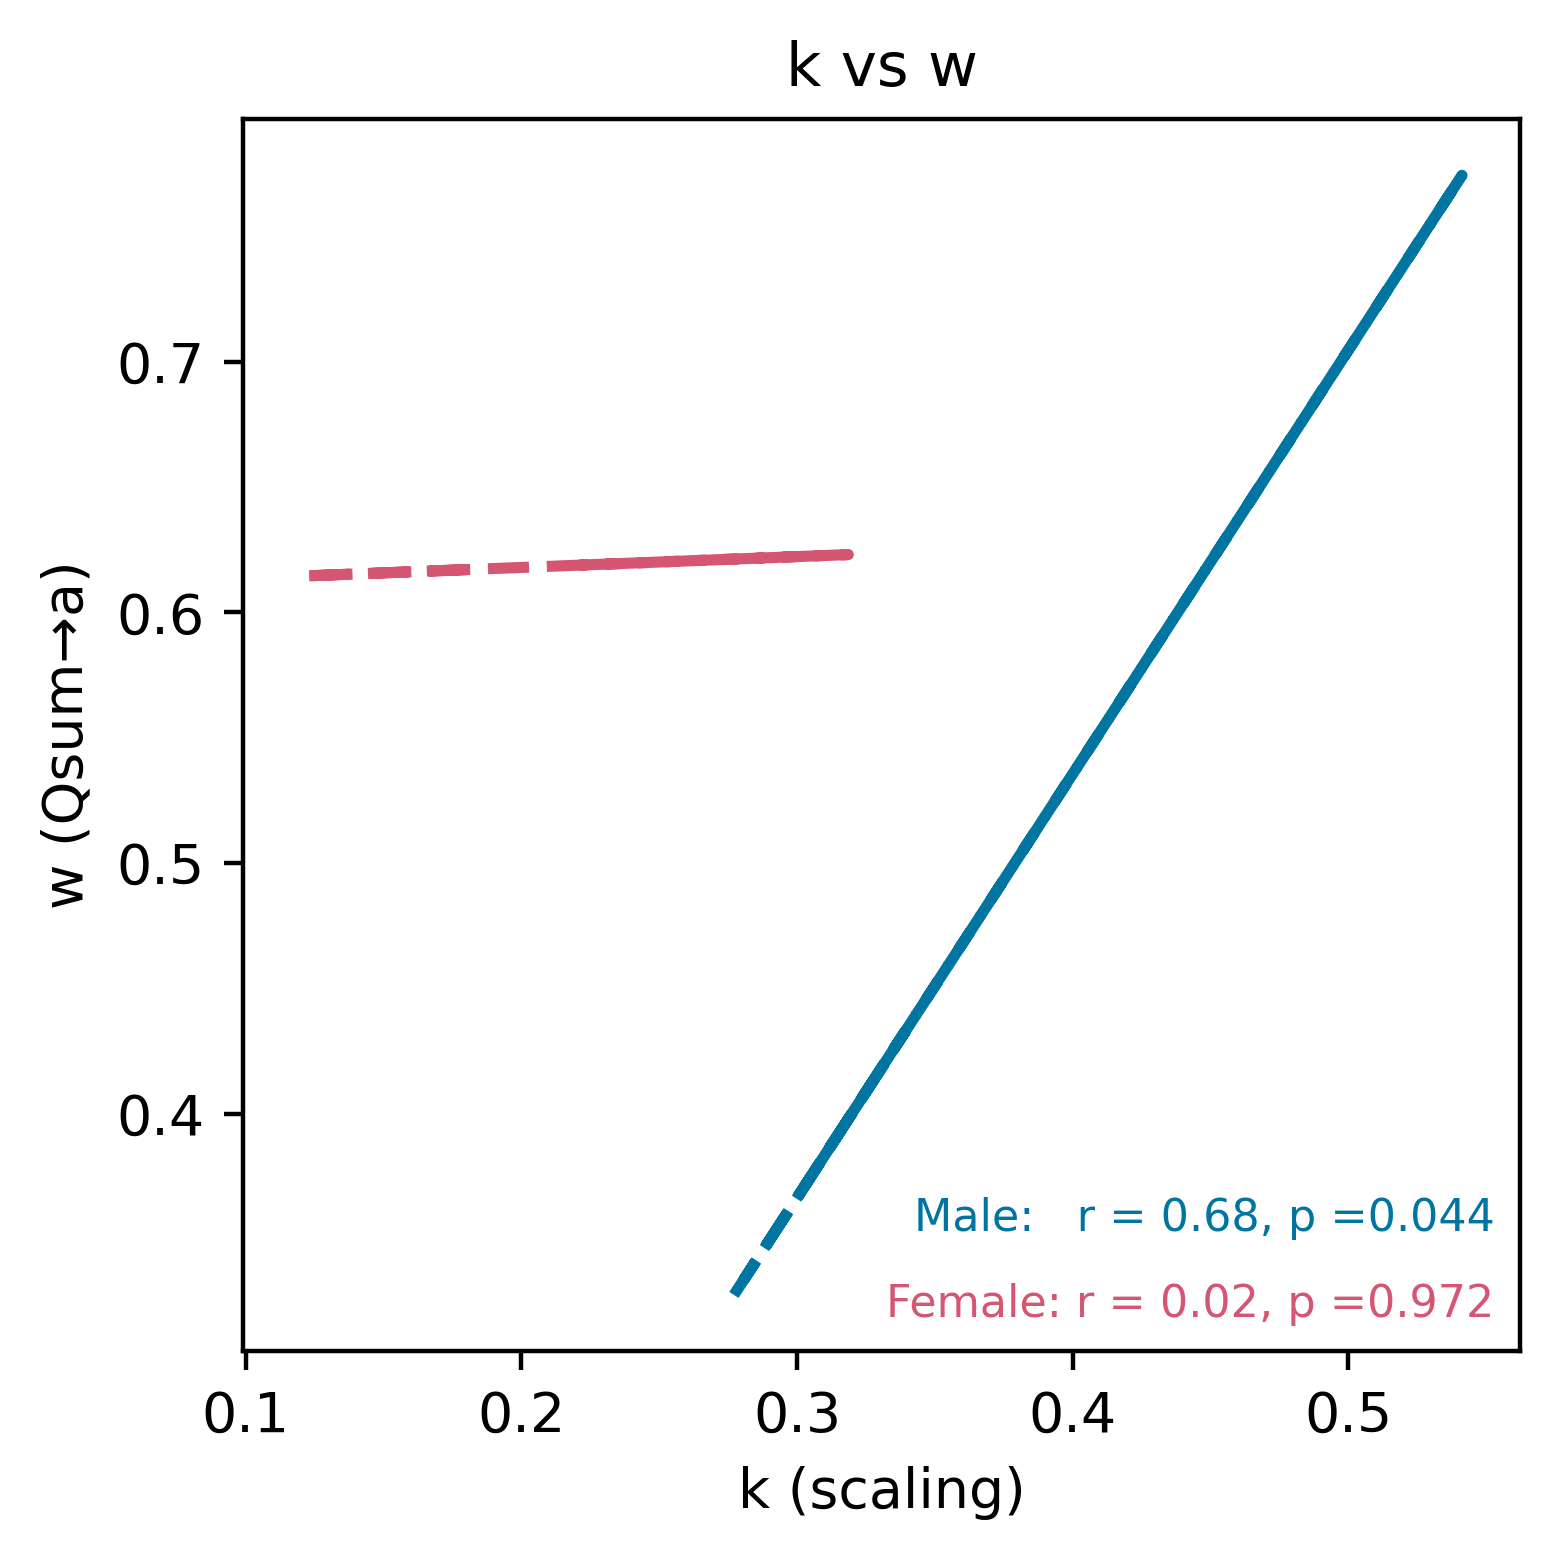

In [ ]:
# example useage.
# since when doing rat level, there are only 14 of them. just copy and paste to here
alpha = np.array([
    0.4501, 0.5796, 0.3898, 0.5157, 0.4328, 0.5356, 0.6396,
    0.4667, 0.4985, 0.5582, 0.6279, 0.4998, 0.5975, 0.4744
])
k = np.array([
    0.2771, 0.3014, 0.3391, 0.2808, 0.1806, 0.3192, 0.1202,
    0.4008, 0.5412, 0.3819, 0.3028, 0.3186, 0.2703, 0.2209
])

a = np.array([
    2.6168, 2.6509, 2.6616, 2.7214, 4.1838, 3.0602, 3.2570,
    2.6325, 2.7152, 2.7491, 3.2914, 3.2270, 2.7181, 3.4229
])

w = np.array([
    0.2096, 0.4459, 0.5028, 0.1845, 0.4014, 0.2577, 0.7032,
    0.7684, 0.6851, 0.4056, 0.5898, 0.6682, 0.5366, 0.7850
])


plot_corr(alpha, k, "α (learning rate)", "k (scaling)", "α vs k", stat_loc='upper left')
plot_corr(k, a, "k (scaling)", "a (boundary)", "k vs a", stat_loc='upper right')
plot_corr(a, w, "a (boundary)", "w (Qsum→a)", "a vs w", stat_loc='lower right')
plot_corr(k, w, "k (scaling)", "w (Qsum→a)", "k vs w", stat_loc='lower right')